[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds-reboot/python-first-part/blob/main/notebooks/hometasks/Task3_dmrf_OOP.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



In [187]:
import requests
import pandas as pd
import json
from tqdm import tqdm
from joblib import Parallel, delayed
from sqlalchemy import create_engine
from pylab import rcParams
import seaborn as sns
from matplotlib import pyplot as plt

## Список объектов

In [4]:
offset_ = 1
limit_ = 1000
url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
res = requests.get(url)
objects_data = res.json()

# Данные по определенному объекту

In [5]:
url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/36774'

In [30]:
class DomIdLoader:
  def __init__(self):
    self.offset_ = 1
    self.limit_ = 1000
    self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'
    self.objects_data = None
    self.objects_ids = []

  def get_ids(self) -> list:
    for i in range(10):
      paramz = {
            'offset': self.offset_,
            'limit': self.limit_,
            'sortField':'devId.devShortCleanNm',
            'sortType':'asc',
            'objStatus':'0',
        }
      res = requests.get(self.url, params=paramz)
    self.objects_data = res.json()

    # final stage - extracting ids
    objects_list = self.objects_data.get('data').get('list')
    objids = [x.get('objId') for x in objects_list]
    self.objects_ids = objids
    return objids

  def show_ids(self):
    print(self.objects_ids)

In [59]:
class ObjectInfoExtractor:
  def __init__(self, ids):
    self.ids = ids
    self.data = []

  @staticmethod
  def extract_data(id):
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{id}'
    res = requests.get(url)
    return res.json()

  def load_data(self, isParallel=False):
    data = []
    if isParallel:
      res = Parallel(n_jobs=16)(delayed(self.extract_data)(id) for id in tqdm(self.ids))
      self.data = res
    else:
      for id in tqdm(self.ids):
        data.append(self.extract_data)
      self.data = data

  def df_converter(self):
    return pd.json_normalize(self.data)

In [105]:
class Saver:
  def __init__(self, data : pd.DataFrame()):
    self.data = data

  def save_csv(self):
    self.data.to_csv('domru_data.cvs')

  def save_xl(self):
    self.data.to_excel('domru_data.xlsx')

  def save_sql(self):
    engine = create_engine('sqlite://', echo=False)
    # convert all columns to str
    # otherwise we should specify types because of errors dutring saving
    df = self.data.applymap(str)
    df.to_sql('domru_data', con=engine)

In [188]:
class Visualizer:
  def __init__(self, data):
    self.data = data

  def make_boxplot(self, x='data.objFlatSq', y='data.objPriceAvg'):
    plot_ = sns.boxplot(data=self.data, x=x, y=y)
    for ind, label in enumerate(plot_.get_xticklabels()):
      if ind % 100 == 0:  # every 100th label is kept
        label.set_visible(True)
      else:
        label.set_visible(False)

  def make_heatmap(self):
    # let's apply only to numeric dtypes
    tmp = self.data.select_dtypes(include='number')
    sns.heatmap(data=tmp, cmap=sns.cubehelix_palette(as_cmap=True))

  def compare_prices_by_region(self):
    # select regions and prices
    df1 = self.data[['data.developer.regRegionDesc','data.objPriceAvg']]
    df1.dropna(inplace=True)

    # group by region
    df2 = df1.groupby('data.developer.regRegionDesc', as_index=False) \
          ['data.objPriceAvg'].mean().sort_values(by=['data.objPriceAvg'], ascending=False)

    df2 = df2.set_index('data.developer.regRegionDesc')
    rcParams['figure.figsize'] = 8,12
    df2.sort_values(ascending=False,by=['data.objPriceAvg'],).plot(kind='barh', color='orange')
    plt.title('Таблица 1.Средние цена за квардратный метр по регионам')
    plt.ylabel("Субъекты Российской Федерации")
    plt.grid('black')
    plt.show()

1. Загружаем ids объектов

In [56]:
loader = DomIdLoader()
ids = loader.get_ids()

  3%|▎         | 31/1000 [03:46<1:58:04,  7.31s/it]


2. Извлекаем данные об объектах

In [60]:
extractor = ObjectInfoExtractor(ids)

Загрузка ~15 минут. Попробуем распаралеллить

Если распараллелить, то примерно 1-2 минуты

In [61]:
extractor.load_data(isParallel=True)



  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 16/1000 [00:01<01:04, 15.30it/s]

  3%|▎         | 32/1000 [00:04<02:12,  7.31it/s]

  5%|▍         | 48/1000 [00:05<01:58,  8.06it/s]

  6%|▋         | 64/1000 [00:06<01:29, 10.47it/s]

  8%|▊         | 80/1000 [00:07<01:12, 12.67it/s]

 10%|▉         | 96/1000 [00:08<01:01, 14.61it/s]

 11%|█         | 112/1000 [00:08<00:55, 16.11it/s]

 13%|█▎        | 128/1000 [00:09<00:52, 16.69it/s]

 14%|█▍        | 144/1000 [00:10<00:49, 17.30it/s]

 16%|█▌        | 160/1000 [00:11<00:46, 18.14it/s]

 18%|█▊        | 176/1000 [00:12<00:44, 18.57it/s]

 19%|█▉        | 192/1000 [00:13<00:42, 19.02it/s]

 21%|██        | 208/1000 [00:13<00:41, 19.00it/s]

 22%|██▏       | 224/1000 [00:14<00:40, 19.27it/s]

 24%|██▍       | 240/1000 [00:15<00:39, 19.06it/s]

 26%|██▌       | 256/1000 [00:16<00:39, 18.94it/s]

 27%|██▋       | 272/1000 [00:17<00:39, 18.22it/s]

 29%|██▉       | 288/1000 [00:18<00:38, 18.59it/s]

 30%|███       | 304/1000 

In [64]:
df = extractor.df_converter()

In [65]:
df.head()

,errcode,data.id,data.hobjId,data.pdId,data.developer.devId,data.developer.devShortCleanNm,data.developer.devShortNm,data.developer.devFullCleanNm,data.developer.problObjCnt,data.developer.buildObjCnt,...,data.metro.colors,data.transportDistIndex,data.transportDistIndexValue,data.complexShortNm,data.airQualityIndexValue,data.developer.bankruptStage.bankruptStageCd,data.developer.bankruptStage.bankruptStageDesc,data.developer.bankruptStage.bankruptLawUrl,data.developer.orgBankruptMsgDttm,data.greenAreaIndexValue
0,0,13383,39024,28105,306,2МЕН ГРУПП,2МЕН ГРУПП,2МЕН ГРУПП,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,13398,37165,28141,306,2МЕН ГРУПП,2МЕН ГРУПП,2МЕН ГРУПП,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,13397,37201,28141,306,2МЕН ГРУПП,2МЕН ГРУПП,2МЕН ГРУПП,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,13399,34754,28141,306,2МЕН ГРУПП,2МЕН ГРУПП,2МЕН ГРУПП,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,10891,6541,23054,3006,ААК ВОЛОГДААГРОСТРОЙ,ААК ВОЛОГДААГРОСТРОЙ,АКЦИОНЕРНАЯ АГРОСТРОИТЕЛЬНАЯ КОМПАНИЯВОЛОГДААГ...,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3. Сэйвим данные

In [102]:
saver = Saver(df)

In [99]:
saver.save_csv()
saver.save_xl()
saver.save_sql()

4. Визуализируем

Надо посмотреть на названия колонок, чтобы посмотреть что может быть потенциально интересным

In [124]:
list(df.columns)

['errcode',
 'data.id',
 'data.hobjId',
 'data.pdId',
 'data.developer.devId',
 'data.developer.devShortCleanNm',
 'data.developer.devShortNm',
 'data.developer.devFullCleanNm',
 'data.developer.problObjCnt',
 'data.developer.buildObjCnt',
 'data.developer.comissObjCnt',
 'data.developer.regRegionDesc',
 'data.developer.devPhoneNum',
 'data.developer.devSite',
 'data.developer.devEmail',
 'data.developer.devInn',
 'data.developer.devOgrn',
 'data.developer.devKpp',
 'data.developer.devLegalAddr',
 'data.developer.devFactAddr',
 'data.developer.lastRpdId',
 'data.developer.fundGuarantyFlg',
 'data.developer.devOrgRegRegionCd',
 'data.developer.devEmplMainFullNm',
 'data.developer.developerGroupName',
 'data.developer.orgForm.id',
 'data.developer.orgForm.fullForm',
 'data.developer.orgForm.shortForm',
 'data.developer.companyGroupId',
 'data.developer.objGuarantyEscrowFlg',
 'data.developer.govFundFlg',
 'data.region',
 'data.address',
 'data.floorMin',
 'data.floorMax',
 'data.objElemL

Потенциально интересными кажутся priceAVG и FlatSQ. Одна из них имеет dtype=object по умолчанию. Нужно конвертировать в float

In [127]:
df['data.objFlatSq'] = df['data.objFlatSq'].astype('float64')

In [189]:
visualizer = Visualizer(df)

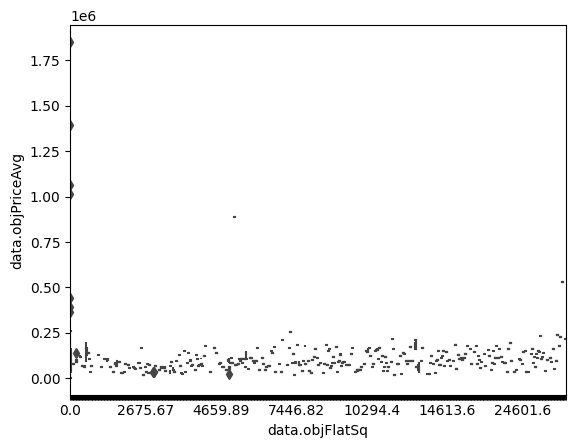

In [139]:
visualizer.make_boxplot()

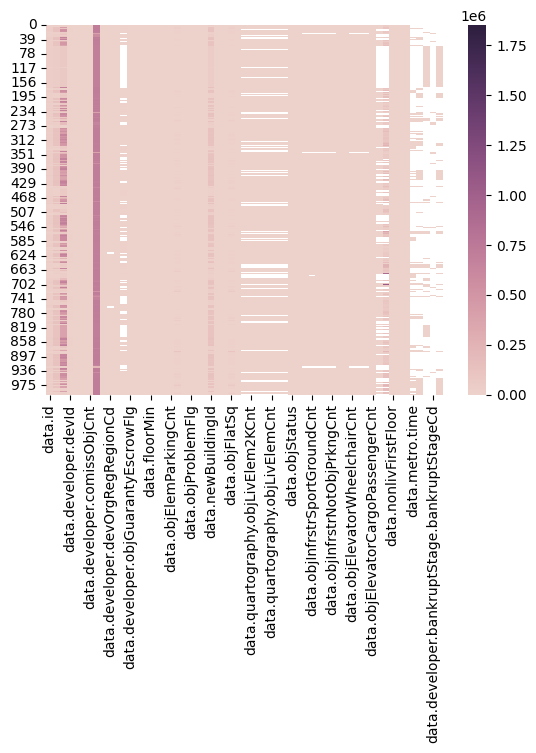

In [177]:
visualizer.make_heatmap()

<ipython-input-188-aabf5e9f16b9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace=True)


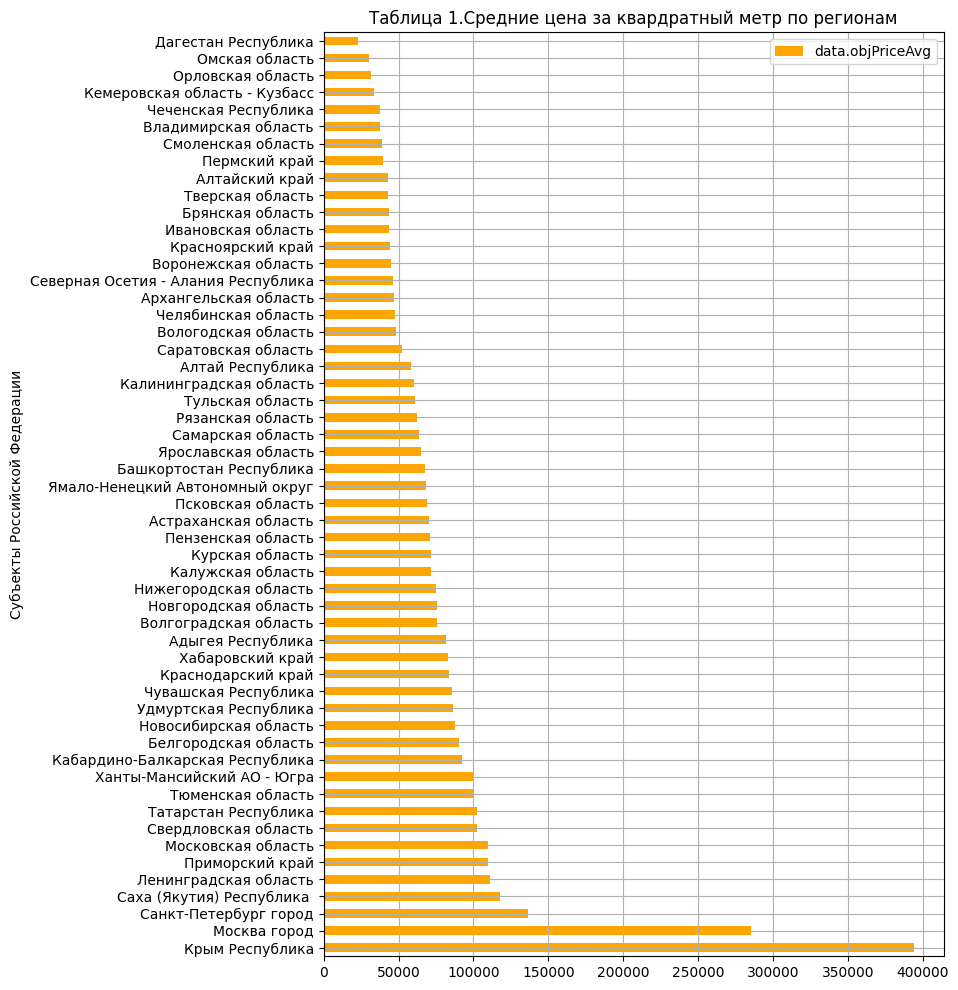

In [190]:
visualizer.compare_prices_by_region()